Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs
# import tarfile

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
import match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, decraoff=None, unit='arcsec', axis_label=None, colorbar=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    if colorbar:
        fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    if axis_label is not None:
        ax.set_xlabel(axis_label[0])
        ax.set_ylabel(axis_label[1])
    return ax

def plot_cutout_sidebyside(img1, img2, title1, title2, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, axis=None):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img1.shape[1]*np.array([-1, 1, 0, 0])+img1.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[0].axvline(0, ls='--', lw=0.5, color='grey')
    axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    axes[0].set_title(title1)
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    axes[1].set_title(title2)
    if axis_label is not None:
        axes[0].set_xlabel(axis_label[0])
        axes[0].set_ylabel(axis_label[1])
        axes[1].set_xlabel(axis_label[0])
        axes[1].set_ylabel(axis_label[1])
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    if axis is not None:
        axes[0].axis(axis)
        axes[1].axis(axis)
    return axes

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [5]:
params = {
'g_weight2': 0.00035, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_weight2': 0.00036, 'z_plexp2': -2.,
}

band = 'g'
field = 'north'
region_name = 'bassmzls'

if (band=='g') or (band=='r'):
    pixscale = 0.454
else:
    pixscale = 0.262

vrange = 0.12

0.91022247953


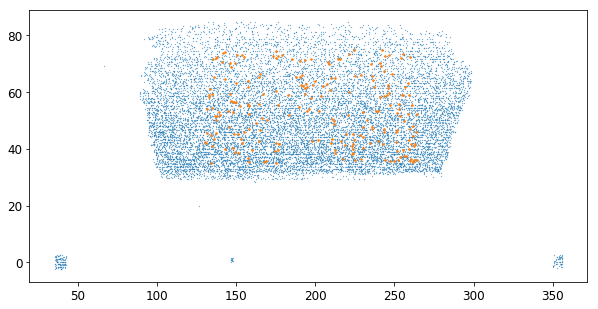

In [6]:
# ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdskycounts', 'ccdskysb']
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']

if (band=='g') or (band=='r'):
    surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/90prime/survey-ccds-90prime-dr8-newlocs.fits.gz'    
else:
    surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/mosaic/survey-ccds-mosaic-dr8-newlocs.fits.gz'

ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

gaia = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_sample-bassmzls.fits')

plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.5)
plt.plot(gaia['ra'], gaia['dec'], '.', ms=3)
plt.show()

In [7]:
# maximum RA, Dec separation for 90prime/Mosaic CCDs
if (band=='g') or (band=='r'):
    max_d_ra, max_d_dec = 4096*0.454/2, 4032*0.454/2  # 90prime
else:
    max_d_ra, max_d_dec = 4079*0.262/2, 4054*0.262/2  # Mosaic   
max_d_ra, max_d_dec = max_d_ra*0.95, max_d_dec*0.95 # trim CCD edges

idx1, idx2, d2d, d_ra, d_dec = match_coord.search_around(gaia['ra'], gaia['dec'], ccd['ra'], ccd['dec'], search_radius=max(max_d_ra, max_d_dec))

mask = np.abs(d_ra)<max_d_ra
mask &= np.abs(d_dec)<max_d_dec
print(np.sum(mask))
mask &= ccd['filter'][idx2]==band
print(np.sum(mask))
idx1 = idx1[mask]
idx2 = idx2[mask]

1051 nearby objects
1050
528


In [11]:
gaia_index = 0
ccd1_index = 0

196.082942602 53.954181318
0   phot_g_mean_mag=6.928   ls_g=8.001
1 CCD images available
alpha, beta = 1.073, 2.682


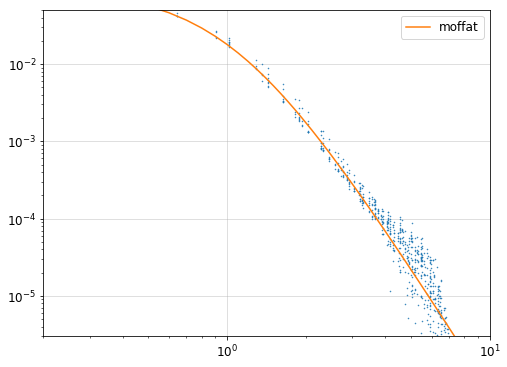

Exposure: 75130097  CCD: CCD4


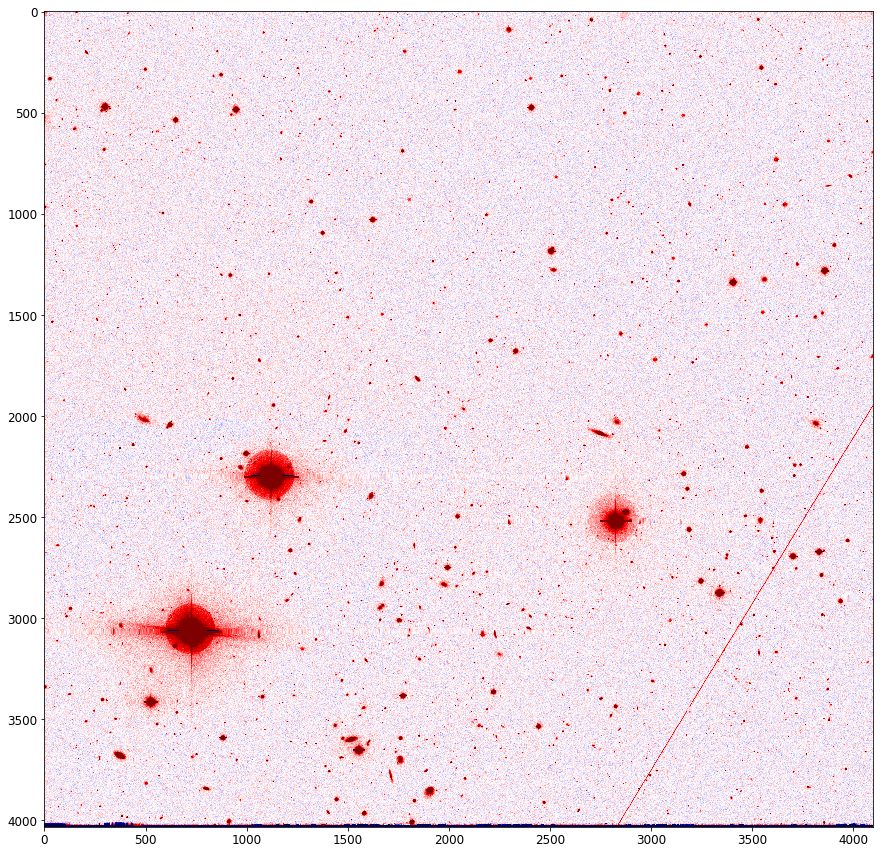

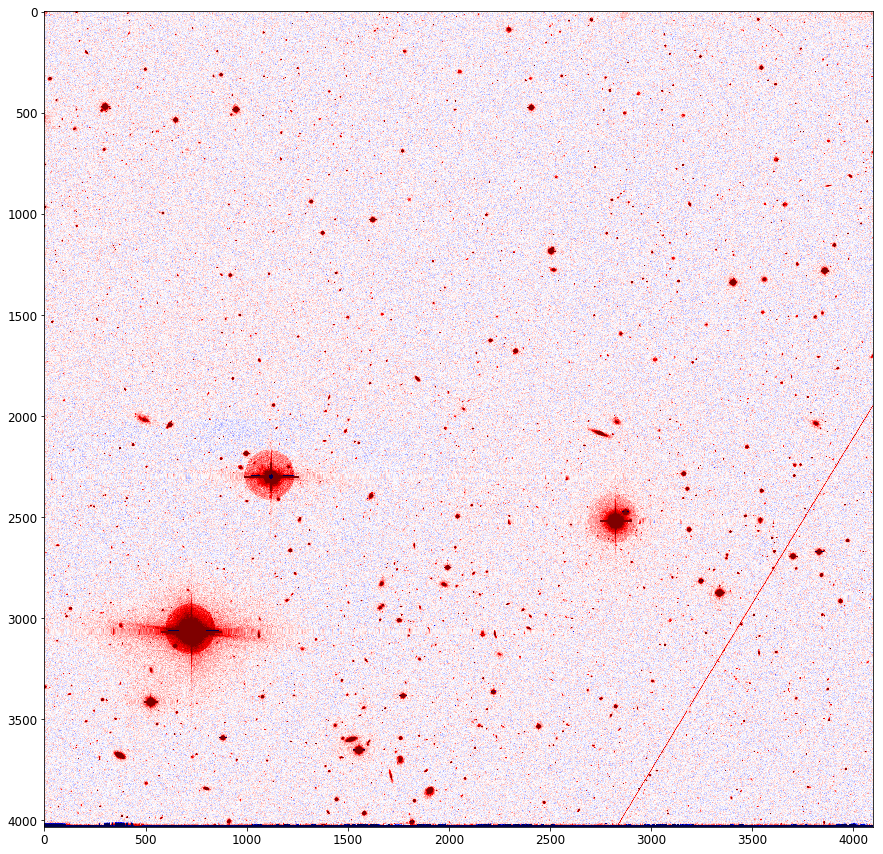

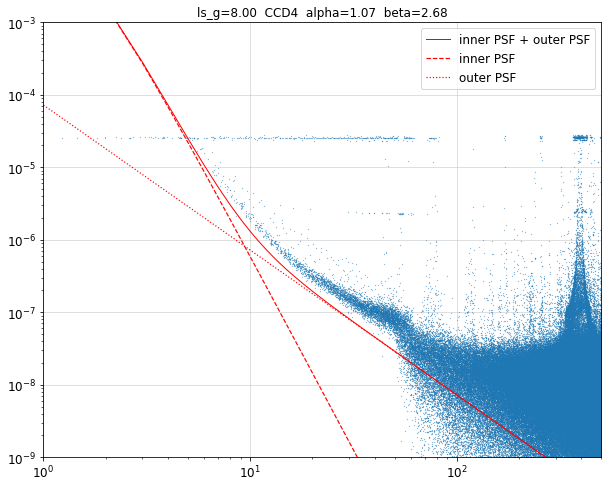

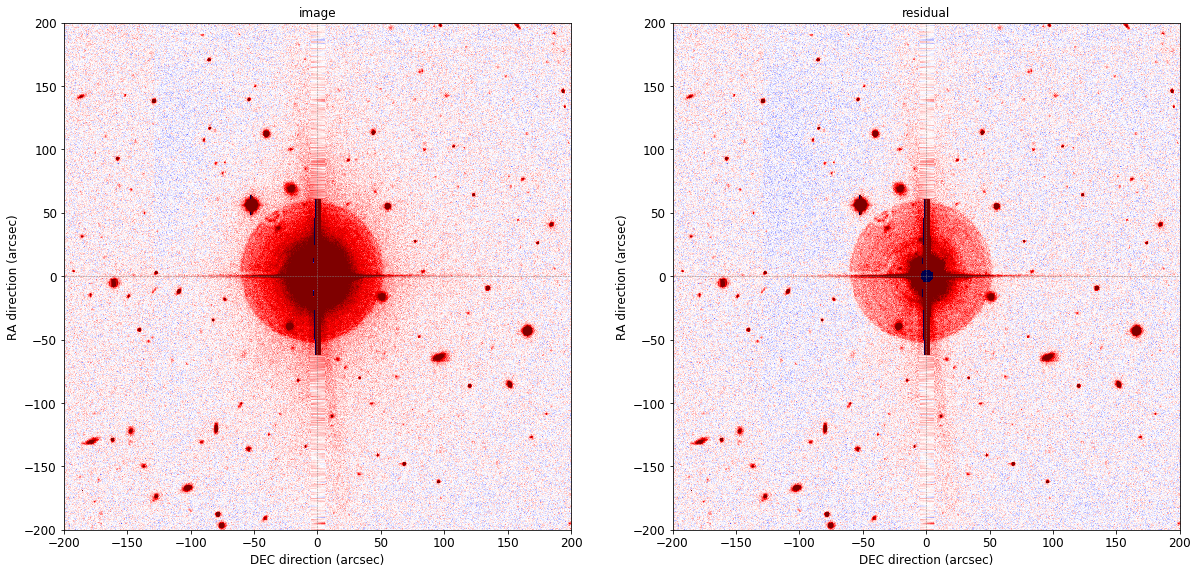

In [12]:
gaia_mask = idx1==gaia_index
if np.sum(gaia_mask)==0:
    raise ValueError

ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
print(ra, dec)
print('{}   phot_g_mean_mag={:.3f}   ls_{}={:.3f}'.format(gaia_index, gaia['phot_g_mean_mag'][gaia_index], band, gaia['ls_'+band][gaia_index]))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ccd1 = ccd[idx2[gaia_mask]]
    print(len(ccd1), 'CCD images available')

    expnum_str = str(ccd1['expnum'][ccd1_index])
    ccdname = ccd1['ccdname'][ccd1_index]
    camera = ccd1['camera'][ccd1_index]
    fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
    # print(fn_prefix)
    # print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
    # print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

    # if band=='z' and (ccdname in outlier_ccd_list):
    #     params_to_use = params_outlier
    # else:
    params_to_use = params
    
    ########## PSFEx ###########
    psfex_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/{}/psfex-merged'.format(camera)
    if band=='z':
        psfex_fn = os.path.join(psfex_dir, '{}/{}-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], camera, (8-len(expnum_str))*'0'+expnum_str))
    else:
        psfex_fn = os.path.join(psfex_dir, '{}/{}-{}.fits'.format((5-len(expnum_str[:5]))*'0'+expnum_str[:5], camera, (8-len(expnum_str))*'0'+expnum_str))
    hdu = fits.open(psfex_fn)
    data = hdu[1].data
    psfex_index = np.where(data['ccdname']==ccdname)[0][0]

    psf0 = data['psf_mask'][psfex_index, 0]
    # normalize to a 22.5 magnitude star
    psf0 = psf0/np.sum(psf0)

    # vrange = 0.0002
    # ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
    # plt.show()

    grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    ################# Moffat fit ##############

    radius_min, radius_max = 1.5, 5.0

    psf0_flat = psf0.flatten()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # popt, pcov =  curve_fit(get_sb_moffat, radius, psf0_flat/(pixscale**2))
        mask = (radius>radius_min) & (radius<radius_max)
        popt, pcov = curve_fit(get_sb_moffat, radius[mask], psf0_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

    alpha, beta = popt
    print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))
    psf_moffat_predict = pixscale**2 * get_sb_moffat(radius_grid, alpha, beta)

    radius_plot = np.linspace(0, 100, 1000)
    psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, psf0_flat, '.', ms=1.)
        plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
        mask = radius_plot>0.5
        # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        # plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        # plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_{}_psfex.png'.format(band, band, gaia_index, ccd1_index, ccdname))
        plt.show()

    ######################################################


    image_dir = '/global/project/projectdirs/cosmo/staging/'
    fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index])
    # print(fn)

    hdulist = fits.open(fn)
    # print(hdu[ccd1['image_hdu'][ccd1_index]].header)
    img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

    # naive sky subtraction
    mask = (img_raw<np.percentile(img_raw.flatten(), 85))
    img = img_raw - np.median(img_raw[mask].flatten())
    # convert to nanomaggie per pixel
    # img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]
    img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5)

    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']

    xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
    ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(xgrid, ygrid)

    # astrometric correction
    ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

    w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
    xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
    if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
        raise ValueError ('outside the CCD!!!')
        # print('outside the CCD!!!')
        # continue

    print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

    ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
    ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

    xx, yy = xx - ccddecoff, yy - ccdraoff

    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    radius_plot = np.linspace(0, 1000, 1000)
    flux = img.flatten()
    # normalization of a 22.5 magnitude star
    norm_factor =  10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)
    
    img_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2) / norm_factor
    flux_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
    flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)

    plt.figure(figsize=(15, 15))
    plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange)
    # plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_{}_img.png'.format(band, band, gaia_index, ccd1_index, ccdname))
    plt.show()

    plt.figure(figsize=(15, 15))
    plt.imshow((img-img_predict).T, cmap='seismic', vmin=-vrange, vmax=vrange)
    # plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_{}_img_subtr.png'.format(band, band, gaia_index, ccd1_index, ccdname))
    plt.show()

    mask = radius<500
    plt.figure(figsize=(10, 8))
    plt.loglog((radius[mask])[::10], norm_factor*(flux[mask])[::10], '.', ms=0.4)
    plt.loglog(radius_plot, flux_plot, 'r-', lw=1, label='inner PSF + outer PSF')
    plt.loglog(radius_plot, flux_plot1, 'r--', lw=1.2, alpha=1., label='inner PSF')
    plt.loglog(radius_plot, flux_plot2, 'r:', lw=1.2, alpha=1., label='outer PSF')
    mask = radius_plot>0.5
    # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot[mask]))), 'y--', lw=1.2, label='polynomial')
    plt.axis([1, 500, 1e-9, 1e-3])
    plt.grid(alpha=0.5)
    plt.title('ls_{}={:.2f}  {}  alpha={:.2f}  beta={:.2f}'.format(band, gaia['ls_'+band][gaia_index], ccdname, alpha, beta))
    plt.legend()
    # plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_{}_profile.png'.format(band, band, gaia_index, ccd1_index, ccdname))
    plt.show()

    ax = plot_cutout_sidebyside(img, img-img_predict, 'image', 'residual', pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200])
    # plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_{}_sidebyside.png'.format(band, band, gaia_index, ccd1_index, ccdname))
    plt.show()

-----
## More plots

In [10]:
for gaia_index in range(0, 60, 2):

    gaia_mask = idx1==gaia_index
    if np.sum(gaia_mask)==0:
        raise ValueError

    ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
    print(ra, dec)
    print('{}   phot_g_mean_mag={:.3f}   ls_{}={:.3f}'.format(gaia_index, gaia['phot_g_mean_mag'][gaia_index], band, gaia['ls_'+band][gaia_index]))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        ccd1 = ccd[idx2[gaia_mask]]
        print(len(ccd1), 'CCD images available')

        for ccd1_index in range(len(ccd1)):

            expnum_str = str(ccd1['expnum'][ccd1_index])
            ccdname = ccd1['ccdname'][ccd1_index]
            camera = ccd1['camera'][ccd1_index]
            fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
            # print(fn_prefix)
            # print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
            # print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

            # if band=='z' and (ccdname in outlier_ccd_list):
            #     params_to_use = params_outlier
            # else:
            params_to_use = params

            ########## PSFEx ###########
            psfex_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/{}/psfex-merged'.format(camera)
            psfex_fn = os.path.join(psfex_dir, '{}/{}-{}.fits'.format((5-len(expnum_str[:5]))*'0'+expnum_str[:5], camera, (8-len(expnum_str))*'0'+expnum_str))
            hdu = fits.open(psfex_fn)
            data = hdu[1].data
            psfex_index = np.where(data['ccdname']==ccdname)[0][0]

            psf0 = data['psf_mask'][psfex_index, 0]
            # normalize to a 22.5 magnitude star
            psf0 = psf0/np.sum(psf0)

            # vrange = 0.0002
            # ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
            # plt.close()

            grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
            xx, yy = np.meshgrid(grid, grid)
            radius_grid = np.sqrt(xx**2 + yy**2)
            radius = radius_grid.flatten()

            ################# Moffat fit ##############

            radius_min, radius_max = 1.5, 5.0

            psf0_flat = psf0.flatten()
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # popt, pcov =  curve_fit(get_sb_moffat, radius, psf0_flat/(pixscale**2))
                mask = (radius>radius_min) & (radius<radius_max)
                popt, pcov = curve_fit(get_sb_moffat, radius[mask], psf0_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

            alpha, beta = popt
            print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))
            psf_moffat_predict = pixscale**2 * get_sb_moffat(radius_grid, alpha, beta)

            radius_plot = np.linspace(0, 100, 1000)
            psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                plt.figure(figsize=(8, 6))
                plt.loglog(radius, psf0_flat, '.', ms=1.)
                plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
                mask = radius_plot>0.5
                # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
                plt.axis([0.2, 10, 3e-6, 0.05])
                plt.grid(alpha=0.5)
                # plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
                plt.legend()
                plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}_bm/{}_{}_{}_{}_psfex.png'.format(band, band, gaia_index, ccd1_index, ccdname))
                plt.close()

            ######################################################


            image_dir = '/global/project/projectdirs/cosmo/staging/'
            fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index])
            # print(fn)

            hdulist = fits.open(fn)
            # print(hdu[ccd1['image_hdu'][ccd1_index]].header)
            img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

            # naive sky subtraction
            mask = (img_raw<np.percentile(img_raw.flatten(), 85))
            img = img_raw - np.median(img_raw[mask].flatten())
            # convert to nanomaggie per pixel
            # img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]
            img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5)

            # plt.hist(img.flatten(), 100, range=(-0.02, 0.02))
            # plt.axvline(0, color='red')
            # plt.close()

            if band=='z':
                alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']
            else:
                plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']

            xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
            ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
            xx, yy = np.meshgrid(xgrid, ygrid)

            # astrometric correction
            ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

            w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
            xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
            if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
                raise ValueError ('outside the CCD!!!')
                # print('outside the CCD!!!')
                # continue

            print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

            ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
            ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

            xx, yy = xx - ccddecoff, yy - ccdraoff

            radius_grid = np.sqrt(xx**2 + yy**2)
            radius = radius_grid.flatten()
            radius_plot = np.linspace(0, 1000, 1000)
            flux = img.flatten()
            # normalization of a 22.5 magnitude star
            norm_factor =  10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)

            if band!='z':
                img_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2) / norm_factor
                flux_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
                flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
                flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
            else:
                img_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2) / norm_factor
                flux_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
                flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
                flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

            plt.figure(figsize=(15, 15))
            plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange)
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}_bm/{}_{}_{}_{}_img.png'.format(band, band, gaia_index, ccd1_index, ccdname))
            plt.close()

            plt.figure(figsize=(15, 15))
            plt.imshow((img-img_predict).T, cmap='seismic', vmin=-vrange, vmax=vrange)
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}_bm/{}_{}_{}_{}_img_subtr.png'.format(band, band, gaia_index, ccd1_index, ccdname))
            plt.close()

            mask = radius<500
            plt.figure(figsize=(10, 8))
            plt.loglog((radius[mask])[::10], norm_factor*(flux[mask])[::10], '.', ms=0.4)
            plt.loglog(radius_plot, flux_plot, 'r-', lw=1, label='inner PSF + outer PSF')
            plt.loglog(radius_plot, flux_plot1, 'r--', lw=1.2, alpha=1., label='inner PSF')
            plt.loglog(radius_plot, flux_plot2, 'r:', lw=1.2, alpha=1., label='outer PSF')
            mask = radius_plot>0.5
            # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot[mask]))), 'y--', lw=1.2, label='polynomial')
            plt.axis([1, 500, 1e-9, 1e-3])
            plt.grid(alpha=0.5)
            plt.title('ls_{}={:.2f}  {}  alpha={:.2f}  beta={:.2f}'.format(band, gaia['ls_'+band][gaia_index], ccdname, alpha, beta))
            plt.legend()
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}_bm/{}_{}_{}_{}_profile.png'.format(band, band, gaia_index, ccd1_index, ccdname))
            plt.close()

            ax = plot_cutout_sidebyside(img, img-img_predict, 'image', 'residual', pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200])
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}_bm/{}_{}_{}_{}_sidebyside.png'.format(band, band, gaia_index, ccd1_index, ccdname))
            plt.close()

196.082942602 53.954181318
0   phot_g_mean_mag=6.928   ls_g=8.001
1 CCD images available
alpha, beta = 1.073, 2.682
Exposure: 75130097  CCD: CCD4
194.628133691 61.7169771346
2   phot_g_mean_mag=6.691   ls_g=7.675
2 CCD images available
alpha, beta = 1.226, 2.607
Exposure: 77850199  CCD: CCD3
alpha, beta = 1.478, 3.123
Exposure: 75450066  CCD: CCD4
174.707971742 39.1726005078
4   phot_g_mean_mag=6.537   ls_g=8.046
4 CCD images available
alpha, beta = 1.232, 3.785
Exposure: 79010047  CCD: CCD3
alpha, beta = 2.662, 3.979
Exposure: 78070082  CCD: CCD3
alpha, beta = 1.750, 2.695
Exposure: 74870072  CCD: CCD2
alpha, beta = 1.271, 2.528
Exposure: 75070052  CCD: CCD2
211.585313294 48.8809184454
6   phot_g_mean_mag=6.976   ls_g=8.023
2 CCD images available
alpha, beta = 1.247, 2.876
Exposure: 75100126  CCD: CCD2
alpha, beta = 0.726, 2.298
Exposure: 74600223  CCD: CCD4
225.01119876 65.4761344771
8   phot_g_mean_mag=6.622   ls_g=7.256
3 CCD images available
alpha, beta = 1.117, 2.957
Exposure: 78